    CLOSE    HIGH     LOW  N_TRADES    OPEN                Time         VALUE    VOLUME        VWAP
0  153.18  153.33  152.22    110896  153.19 2017-06-01 04:00:00  2.158115e+09  14117099  152.872390
1  155.45  155.45  152.89    165871  153.60 2017-06-02 04:00:00  3.766990e+09  24371642  154.564458
2  153.93  154.45  153.15    154611  154.38 2017-06-05 04:00:00  3.383840e+09  21986991  153.901909
3  154.45  155.81  153.78    149774  153.90 2017-06-06 04:00:00  3.547797e+09  22934050  154.695602
4  155.37  155.98  154.48    127897  155.02 2017-06-07 04:00:00  2.906467e+09  18708571  155.354817
5  154.92  155.55  154.40    130480  155.29 2017-06-08 04:00:00  2.640404e+09  17047039  154.889325
6  148.97  155.20  146.02    413396  155.18 2017-06-09 04:00:00  8.962529e+09  59642405  150.271078
7  145.40  146.09  142.51    446732  145.63 2017-06-12 04:00:00  9.510026e+09  65926020  144.252996
8  146.59  153.42  144.23    204974  147.16 2017-06-13 04:00:00  4.083263e+09  27900456  146.351110


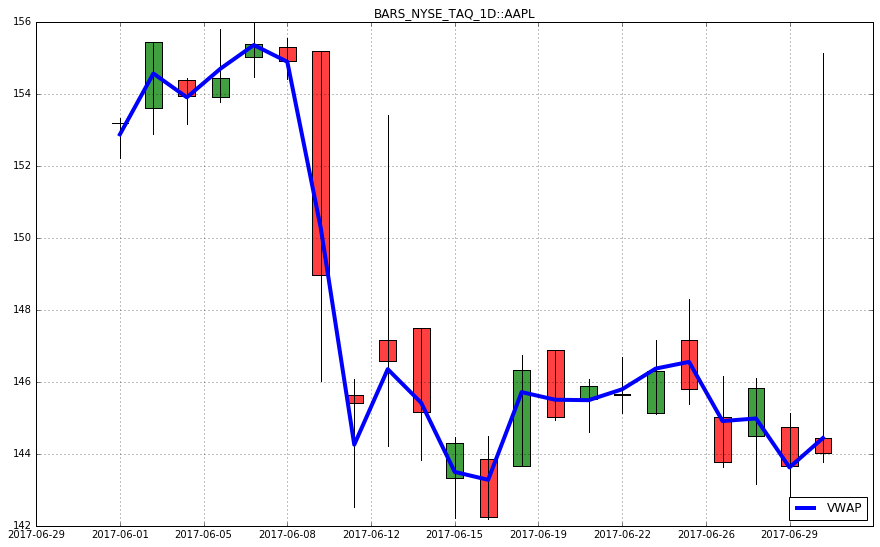

In [1]:
# A simple Chain query retrieves pre-computed bars
# Results are printed/plotted using matplotlib
import quersive as q
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# from https://matplotlib.org/examples/pylab_examples/finance_demo.html
from matplotlib.finance import candlestick2_ohlc
import matplotlib.ticker as ticker

sym = ["BARS_NYSE_TAQ_1D::AAPL","BARS_NYSE_TAQ_1D::IBM"]
CONTEXT = "ESTRELLA_59050"
start_date, end_date = datetime(2017,5,1,0,0), datetime(2017,7,1,0,0)

c = q.Chain('Passthrough', ticktype='1DAY_TRD')

# run query and print results
data = q.run_query(c, symbol=sym, context=CONTEXT, s=start_date, e=end_date, timezone='GMT')
df = pd.DataFrame(data[sym[0]])
pd.set_option('display.width', 200) # printout width 
print(df.head(10))

# plot results
fig, ax = plt.subplots(figsize=(15, 10)) # bigger size!
fig.subplots_adjust(bottom=0.2)

# build a canclestick plot for HLOC data
candlestick2_ohlc(ax, \
                  df['OPEN'], df['HIGH'], df['LOW'], df['CLOSE'],
                  width=0.5,
                  colorup="green")

xdate = [datetime.strptime(str(i), "%Y-%m-%d %H:%M:%S") for i in df['Time'] ]
def mydate(x,pos):
    try:
        s = str(xdate[int(x)])
        return s[:10]
    except IndexError:
        return ''

ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(mydate))

# add a line plot for VWAP
plt.plot(data[sym[0]]['VWAP'], label = 'VWAP', linewidth=4)

#fig.autofmt_xdate() # prints dates at 45 degree angle
#fig.tight_layout()

ax.xaxis_date()
ax.autoscale_view()
#plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right') # other way to print x axis labels at 45 degrees

plt.title(sym[0])
plt.grid()
plt.legend(loc=4)
plt.show()

    HALF  SPREAD_BP       Time
0   0930  13.338653 2017-02-01
1   1000   6.750657 2017-02-01
2   1030   5.303398 2017-02-01
3   1100   4.312286 2017-02-01
4   1130   4.065492 2017-02-01
5   1200   3.846005 2017-02-01
6   1230   3.510142 2017-02-01
7   1300   3.641795 2017-02-01
8   1330   3.096152 2017-02-01
9   1400   3.364645 2017-02-01
10  1430   3.898168 2017-02-01
11  1500   3.201420 2017-02-01
12  1530   6.061745 2017-02-01


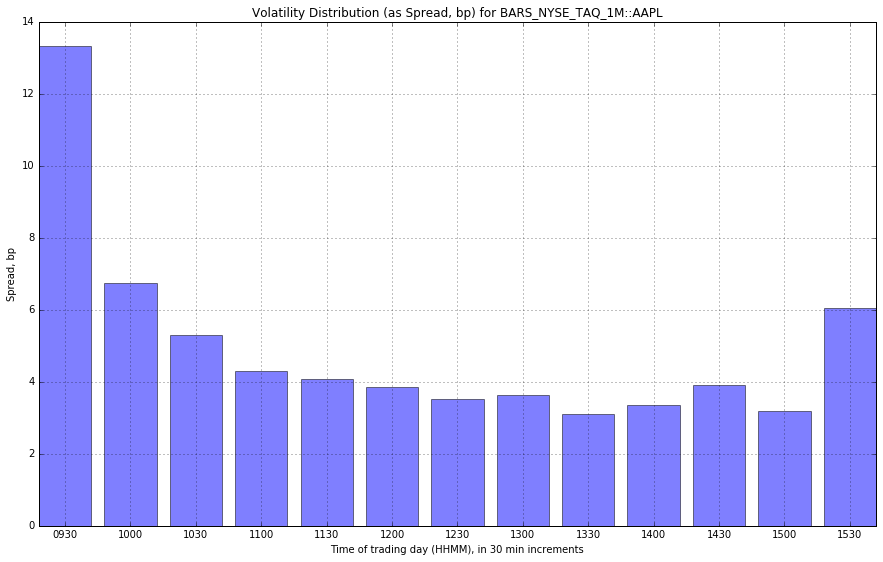

In [2]:
# histogram of 30 min avg spreads (volatility distribution)

import quersive as q
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.finance import index_bar
import matplotlib.ticker as ticker

sym = ["BARS_NYSE_TAQ_1M::AAPL"]
CONTEXT = "ESTRELLA_59050"
start_date, end_date = datetime(2017,1,3,0,0), datetime(2017,2,1,0,0)

c = q.Graph(q.add_fields(ticktype='1MINUTE_TRD', fields=' \
              double SPREAD_BP = ((HIGH-LOW) / VWAP) * 10000, \
              string[4] HHMM = TIME_FORMAT("%H%M", TIMESTAMP, "EST5EDT"), \
              string[2] HH = TIME_FORMAT("%H", TIMESTAMP, "EST5EDT"), \
              string[4] HALF = TIME_FORMAT("%H%M", 1800000 * DIV(TIMESTAMP, 30*60*1000), "EST5EDT")'))
c >> q.passthrough(fields='SPREAD_BP, HHMM, HH, HALF') >> q.average(input_field_name = 'SPREAD_BP', output_field_name = 'SPREAD_BP', group_by = 'HALF')

# run query and print results
data = q.run_query(c, symbol=sym, context=CONTEXT, s=start_date, e=end_date, timezone='EST5EDT')
df = pd.DataFrame(data[sym[0]])
pd.set_option('display.width', 200) # printout width 
print(df.head(20))

# plot results
fig, ax = plt.subplots(figsize=(15, 10)) # bigger size!
fig.subplots_adjust(bottom=0.2)
index = np.arange(len(df['SPREAD_BP']))

rects1 = plt.bar(index, df['SPREAD_BP'], align='center', alpha=0.5)
plt.xticks(index, df['HALF']) # set x ticks
plt.ylabel('Spread, bp')
plt.xlabel('Time of trading day (HHMM), in 30 min increments')

ax.autoscale_view()

plt.title('Volatility Distribution (as Spread, bp) for ' + sym[0])
plt.grid()
#plt.legend(loc=4)
plt.show()

In [3]:
# order book scope (how a large trade affects the order book)
# Using Plotly (simpler that Matplotlib, imho)

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
from plotly.tools import set_config_file
from datetime import datetime
import pytz
import quersive as q
import pandas as pd
init_notebook_mode(connected=True)
set_config_file(world_readable=False, sharing='private')
# For plotly to work you need to have an account with Plotly and your
# credentials file C:\Users\kirill\.plotly\.credentials needs to be 
# set up with your userid, API key and (if applicable) streams ID.
# print(__version__) # requires version >= 1.9.0

# set up OneTick query parameters
sym = ["MS151::VOD.151"]
CONTEXT = "SUBARU-50001-h"

nyc = pytz.timezone("America/New_York")
lon = pytz.timezone("Europe/London")
start_date, end_date = datetime(2017,5,12,10,43), datetime(2017,5,12,10,44)
start_date = lon.localize(start_date) 
end_date = lon.localize(end_date)     
#print('start: ' + start_date.isoformat())
#print('end: ' + end_date.isoformat())

# build graph
# Bottom-most TABLE is required to set all empty PRICE cells to NaNs. This is because in the plot we
# will skip all NaNs. And we do not plot SIZEs, which are set to 0, so no need to do anything special for them.
g = q.Graph(q.table(fields='double PRICE, long SIZE, \
double ASK_PRICE1, long ASK_SIZE1,\
double ASK_PRICE2, long ASK_SIZE2,\
double ASK_PRICE3, long ASK_SIZE3,\
double BID_PRICE1, long BID_SIZE1,\
double BID_PRICE2, long BID_SIZE2,\
double BID_PRICE3, long BID_SIZE3'))
#g = q.Graph(q.passthrough(fields='PRICE|SIZE', use_regex='true'))
g.source(q.passthrough(fields='PRICE|SIZE', use_regex='true'))
m = g.source(q.merge()).head
g.source(q.ob_snapshot_flat(ticktype='PRL_FULL', is_running_aggr='true', max_levels='3'))
g.head = m
g.source(q.passthrough(ticktype='TRD', fields='PRICE, SIZE'))
q.render(g)
g.save(sym, start_date, end_date, timezone='EST5EDT', otq_file='C:\Temp\scratch.otq', query_name='obs')

# run query and print results
data = q.run_query(g, symbol=sym, context=CONTEXT, s=start_date, e=end_date, timezone='EST5EDT')
df = pd.DataFrame(data[sym[0]])
pd.set_option('display.width', 200) # printout width 
df['Time'] = df['Time'] - pd.Timedelta(4, unit='h') # adjust time zone in the result set (from Local to London)
print(df.head(5))

# Create a bunch of scatter plots
ask_marker_symbol = "triangle-down"
bid_marker_symbol = "triangle-up"
ask1 = Scatter(x = df['Time'],y = df['ASK_PRICE1'], mode = 'markers', name='ask1',
               marker = dict(size = 10,color = '#6495ed',symbol=ask_marker_symbol)) # , line = dict(width = 2, color = 'rgb(0, 0, 0)')
ask2 = Scatter(x = df['Time'],y = df['ASK_PRICE2'], mode = 'markers', name='ask2', 
               marker = dict(size = 10,color = '#0000ff',symbol=ask_marker_symbol))
ask3 = Scatter(x = df['Time'],y = df['ASK_PRICE3'], mode = 'markers', name='ask3', 
               marker = dict(size = 10,color = '#191970',symbol=ask_marker_symbol))

bid1 = Scatter(x = df['Time'],y = df['BID_PRICE1'], mode = 'markers', name='bid1', 
               marker = dict(size = 10,color = '#ff6347',symbol=bid_marker_symbol))
bid2 = Scatter(x = df['Time'],y = df['BID_PRICE2'], mode = 'markers', name='bid2', 
               marker = dict(size = 10,color = '#ff4500',symbol=bid_marker_symbol))
bid3 = Scatter(x = df['Time'],y = df['BID_PRICE3'], mode = 'markers', name='bid3', 
               marker = dict(size = 10,color = '#ff0000',symbol=bid_marker_symbol))

trade = Scatter(x = df['Time'],y = df['PRICE'], mode = 'markers', name='trade', 
               marker = dict(size = df['SIZE']/200,color = 'black')) # trade marker size is proportional to trade SIZE

data = [ask1, ask2, ask3, bid1, bid2, bid3, trade]

# Plot and embed in ipython notebook!
iplot(data, filename='basic-scatter')


   ASK_PRICE1  ASK_PRICE2  ASK_PRICE3  ASK_SIZE1  ASK_SIZE2  ASK_SIZE3  BID_PRICE1  BID_PRICE2  BID_PRICE3  BID_SIZE1  BID_SIZE2  BID_SIZE3  PRICE  SIZE                    Time
0      210.95       211.0      211.05      39636      60603      74930       210.9      210.85       210.8      28625      59483      68452    NaN     0 2017-05-12 06:43:00.000
1      210.95       211.0      211.05      39636      63603      74930       210.9      210.85       210.8      28625      59483      68452    NaN     0 2017-05-12 06:43:00.926
2      210.95       211.0      211.05      39636      63603      74930       210.9      210.85       210.8      31125      59483      68452    NaN     0 2017-05-12 06:43:01.987
3      210.95       211.0      211.05      37136      63603      74930       210.9      210.85       210.8      31125      59483      68452    NaN     0 2017-05-12 06:43:01.987
4      210.95       211.0      211.05      37136      63603      74930       210.9      210.85       210.8      339